In [1]:
import copy
%load_ext autoreload
%autoreload 2
%run Datasets.ipynb
import numpy as np
from keras import Input, Model
from keras.src.layers import Dense, BatchNormalization, GaussianNoise
from src import HammingCode


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-06-10 16:22:56.115208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 16:22:56.115309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 16:22:56.117428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 16:22:56.131328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 16:22:57.355164: W tensorflow/compiler/tf2

In [2]:
code_rate = 4/7
neurons = 7

entrada = Input(shape=(SIZE,))
encoder1 = Dense(SIZE, activation='relu')(entrada)
encoder2 = Dense(neurons, activation='linear')(encoder1)
encoder3 = BatchNormalization()(encoder2)


Eb_treinamento = 5.01187 * code_rate

noise = GaussianNoise(np.sqrt(1/(2* Eb_treinamento)))(encoder3)

decoder1 = Dense(SIZE, activation='relu')(noise)
decoder2 = Dense(SIZE, activation='softmax')(decoder1)

autoencoder = Model(entrada, decoder2)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
autoencoder.fit(
    training_data,
    training_data,
    epochs=20,
    batch_size=300,
    validation_data=(validation_data, validation_data),
)

# Com o modelo treinado, separa em encoder e decoder
encoder = Model(entrada, encoder3)

entrada_encoder = Input(shape=(7,))
decoder_layer1 = autoencoder.layers[-2](entrada_encoder)
decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
decoder = Model(entrada_encoder, decoder_layer2)

Epoch 1/20
34/34 [==============================] - 2s 13ms/step - loss: 0.8914 - accuracy: 0.6636 - val_loss: 1.2427 - val_accuracy: 0.5000
Epoch 2/20
34/34 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.7783 - val_loss: 1.1404 - val_accuracy: 0.5000
Epoch 3/20
34/34 [==============================] - 0s 6ms/step - loss: 0.5479 - accuracy: 0.8311 - val_loss: 0.9829 - val_accuracy: 0.7580
Epoch 4/20
34/34 [==============================] - 0s 5ms/step - loss: 0.4080 - accuracy: 0.9512 - val_loss: 0.8110 - val_accuracy: 1.0000
Epoch 5/20
34/34 [==============================] - 0s 5ms/step - loss: 0.2681 - accuracy: 0.9975 - val_loss: 0.6529 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 0s 5ms/step - loss: 0.1730 - accuracy: 0.9997 - val_loss: 0.4898 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 0s 5ms/step - loss: 0.1211 - accuracy: 0.9999 - val_loss: 0.3486 - val_accuracy: 1.0000
Epoch 8/20
34/34 [=

In [4]:
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import Sequential

# MLP

noise_for_training = np.sqrt((1/(2*Eb_treinamento))) * np.random.randn(training_length, 4)    
noisy_input_for_training = training_data + noise_for_training

noise_for_validation = np.sqrt((1/(2*Eb_treinamento))) * np.random.randn(validation_length, 4)    

noisy_input_for_validation = validation_data + noise_for_validation
mlp = Sequential()
mlp.add(Input(shape=(4,)))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(4, activation='sigmoid'))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

mlp.fit(
    noisy_input_for_training,
    training_data,
    epochs=20,
    batch_size=300,
    validation_data=(noisy_input_for_validation, validation_data),
)

loss, accuracy = mlp.evaluate(noisy_input_for_validation, validation_data)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/20
34/34 [==============================] - 1s 16ms/step - loss: 0.3241 - accuracy: 0.8211 - val_loss: 0.1255 - val_accuracy: 0.9080
Epoch 2/20
34/34 [==============================] - 0s 10ms/step - loss: 0.1450 - accuracy: 0.8900 - val_loss: 0.1221 - val_accuracy: 0.9080
Epoch 3/20
34/34 [==============================] - 0s 10ms/step - loss: 0.1435 - accuracy: 0.8860 - val_loss: 0.1241 - val_accuracy: 0.9050
Epoch 4/20
34/34 [==============================] - 0s 9ms/step - loss: 0.1411 - accuracy: 0.8867 - val_loss: 0.1242 - val_accuracy: 0.9010
Epoch 5/20
34/34 [==============================] - 0s 9ms/step - loss: 0.1402 - accuracy: 0.8891 - val_loss: 0.1226 - val_accuracy: 0.9050
Epoch 6/20
34/34 [==============================] - 0s 9ms/step - loss: 0.1398 - accuracy: 0.8890 - val_loss: 0.1241 - val_accuracy: 0.9020
Epoch 7/20
34/34 [==============================] - 0s 9ms/step - loss: 0.1412 - accuracy: 0.8875 - val_loss: 0.1236 - val_accuracy: 0.9060
Epoch 8/20
34/34 

In [5]:
from math import erfc

Eb_dB_values = np.arange(-4, 11, 1)
ber_autoencoder = []
ber_Hamming = []
ber_teorica = []
ber_mlp = []
for i in range(0, len(Eb_dB_values)):
    
    
    Eb = 10**(Eb_dB_values[i]/10)
    quantidade_amostras = test_length / SIZE
    
    testing_data_autoencoder = copy.deepcopy(testing_data)
    merged_sample = np.concatenate(testing_data_autoencoder)
    
    testing_data_hamming = copy.deepcopy(merged_sample)
    testing_data_mlp = copy.deepcopy(testing_data)
    merged_testing_data_mlp = copy.deepcopy(merged_sample)
    noise = np.sqrt((1/(2*code_rate*Eb))) * np.random.randn(test_length, 7)    
    
    noise_hamming = copy.deepcopy(noise)
    noise_mlp = copy.deepcopy(noise)
    
    # codifica para 7 bits
    codificado = encoder.predict(testing_data_autoencoder)
    
    #print(codificado)
    # add ruido
    codificado_com_ruido = codificado + noise
    
    #corrige com o decoder
    corrigido = decoder.predict(codificado_com_ruido)
    corrigido_merged = np.concatenate(corrigido)
    corrigido_merged_digital = [1 if bit > 0.5 else 0 for bit in corrigido_merged]
    calculated_ber = np.sum(np.array(corrigido_merged_digital).astype(int) != merged_sample.astype(int)) / len(merged_sample)
    ber_autoencoder.append(calculated_ber)
    print('SNR ', Eb_dB_values[i], 'BER ', calculated_ber)

    ####################### Hamming code
    # Merge sample to encode
    split_encoded_data, split_original_data, merged_encoded_data = HammingCode.encode_sample(testing_data_hamming)

    # Add noise
    merged_encoded_data = [1.0 if bit == 1 else -1.0 for bit in merged_encoded_data]
    merged_noise = np.concatenate(noise_hamming)
    merged_encoded_data = merged_encoded_data + np.array(merged_noise)
    digital_encoded_noisy = np.array([1 if x > 0 else 0.0 for x in merged_encoded_data])
    
    split_digital_encoded_noisy = np.array_split(digital_encoded_noisy, int(len(digital_encoded_noisy)/7))
    
    decoded_sample = HammingCode.decode_sample(split_digital_encoded_noisy)
    calculated_ber_Hamming = np.sum(np.array(decoded_sample).astype(int) != testing_data_hamming.astype(int)) / len(testing_data_hamming)
    ber_Hamming.append(calculated_ber_Hamming)
    
    print('SNR ', Eb_dB_values[i], 'BER ', calculated_ber_Hamming)    
    
    ####################### MLP
    noise_smaller = noise_mlp[:, :4]
    amostra_ruidosa = testing_data_mlp + noise_smaller
    
    mlp_corrigido = mlp.predict(amostra_ruidosa)
    
    mlp_corrigido_merged = np.concatenate(mlp_corrigido)
    mlp_corrigido_merged_digital = [1 if bit > 0.5 else 0 for bit in mlp_corrigido_merged]
    calculated_ber_mlp = np.sum(np.array(mlp_corrigido_merged_digital).astype(int) != merged_testing_data_mlp.astype(int)) / len(merged_testing_data_mlp)
    ber_mlp.append(calculated_ber_mlp)
    print('SNR ', Eb_dB_values[i], 'BER ', calculated_ber_mlp)

3125/3125 [==============================] - 6s 2ms/step
SNR  -4 BER  0.0610525
SNR  -4 BER  0.2620725
3125/3125 [==============================] - 8s 3ms/step
SNR  -4 BER  0.2756825
3125/3125 [==============================] - 6s 2ms/step
SNR  -3 BER  0.0424625
SNR  -3 BER  0.2294275
3125/3125 [==============================] - 8s 3ms/step
SNR  -3 BER  0.259525
3125/3125 [==============================] - 6s 2ms/step
SNR  -2 BER  0.0277875
SNR  -2 BER  0.194605
3125/3125 [==============================] - 8s 3ms/step
SNR  -2 BER  0.2461775
3125/3125 [==============================] - 6s 2ms/step
SNR  -1 BER  0.0156475
SNR  -1 BER  0.156695
3125/3125 [==============================] - 8s 3ms/step
SNR  -1 BER  0.23037
3125/3125 [==============================] - 6s 2ms/step
SNR  0 BER  0.00793
SNR  0 BER  0.1197575
3125/3125 [==============================] - 8s 3ms/step
SNR  0 BER  0.21273
3125/3125 [==============================] - 6s 2ms/step
SNR  1 BER  0.0035725
SNR  1 BER  0.0851

In [6]:
Eb_values_BPSK = 10**(Eb_dB_values/10)
BPSK = [0.5 * erfc(np.sqrt(each)) for each in Eb_values_BPSK]

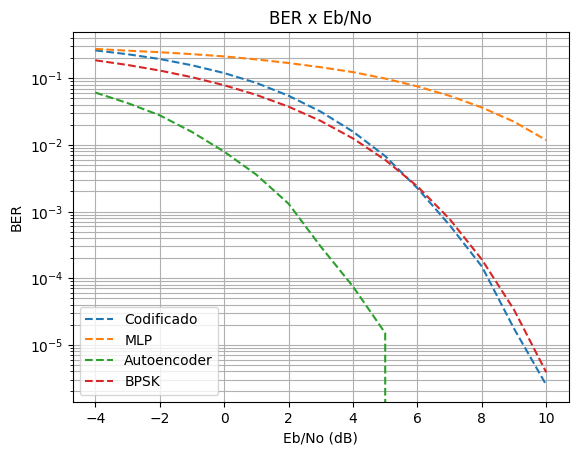

In [8]:
from matplotlib import pyplot as plt

plt.semilogy(Eb_dB_values, ber_Hamming, marker='', linestyle='--', label='Codificado')
plt.semilogy(Eb_dB_values, ber_mlp, marker='', linestyle='--', label='MLP')

plt.semilogy(Eb_dB_values, ber_autoencoder, marker='', linestyle='--', label='Autoencoder')
plt.semilogy(Eb_dB_values, BPSK, marker='', linestyle='--', label='BPSK')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')

plt.show()
